# Reservoir Management for Profit Maximisation



*** This example optimisation problem and some of the description were borrowed from or inspired by a Mathworks Tutorial** https://nl.mathworks.com/company/newsletters/articles/solving-large-scale-optimization-problems-with-matlab-a-hydroelectric-flow-example.html


## Optimization Goal



In this exercise, we consider the management of a reservoir that produces electricity and supplies some municipal water needs. The dam can be considered as a storage with a single inlet for inflow and its outlet in the form of a turbine flow to the hydrelectric plant and a spillway. The municipal water use downstream of the reservoir is derived from the total outflow from the dam.


Our hydroelectric power plant model includes the inlet flow into the reservoir from the river and the storage level of the reservoir.

![A Hydroelectric power plant diagram](https://nl.mathworks.com/content/mathworks/nl/en/company/newsletters/articles/solving-large-scale-optimization-problems-with-matlab-a-hydroelectric-flow-example/jcr:content/mainParsys/image_1.adapt.full.high.jpg/1469941472478.jpg)

                  
                                Fig. 1: A Hydroelectric power plant diagram. 

Water can leave the reservoir either through the spillway or via the turbine. Water that leaves through the turbine is used to generate electricity. We can sell this electricity at prices that are determined by various market factors. We control the rates at which water flows through the spillway and the turbine. Our goal is to find values for these rates that will maximize revenue over a long prediction horizon for inflows and electricity prices.

The best values for the hydroelectric flow rates are found over several days at hourly intervals. As a result, we need to find the flow values at each hour, which means that the size of the problem will increase the longer we run the control optimisation problem.

## Defining System Dynamics and Control Variables 

We use the following equations to describe the objectives and the dynamics of the given system. The first is the empirical equation for the turbine, and relates the electricity produced to the turbine flow and reservoir levels. The second gives the reservoir storage level as a function of the flow into and out of the reservoir.

\begin{eqnarray}
E(t) &= Q_T(t-1)*[½ k_1(S(t) + S(t-1)) + k_2]   &\quad(1)  \\
S(t) &= S(t-1) + ∆t * [Q_{in}(t-1) - Q_{SP}(t-1) - Q_T(t-1)] &\quad (2) 
\end{eqnarray}



The amount of electricity produced is a function of the amount of water flowing to the turbine and the storage level in the reservoir; see  Equation (1). This means that the higher the water level in the reservoir, the more power will be produced for a given turbine flow.

Certain physical constraints need to be taken into consideration. Both the reservoir level and downstream flow rates must remain within specified ranges. The maximum level of flow that the turbine can handle is set, but the spillway level is unrestricted. 

The power plant will continue to operate beyond the period for which we are optimizing, so we need to prevent the solver from finding a solution that empties the reservoir or is optimal only in the short term. To guarantee performance over longer periods, we can constrain the storage level at the end of the prediction horizon. A typical assumption to make is that electricity price variations have diurnal or weekly patterns. With such assumptions, we can employ what is called cylic control -- i.e. we enforce that the reservoir level at the end of the simulation must be the same as the level at the start of the simulation. 

All the constraints for this problem are linear, meaning they can be expressed in matrix notation. Our objective, however, is nonlinear, making the resulting optimization problem a nonlinear program (NLP).


## Problem Data and Constraints


This problem is constrained such that:

*   0 < Turbine Flow < 10000 CFS
*   Maximum change in Turbine and Spill Flow < 500 CFS per hour
*   Combined Turbine and Spill Flow > 1000 CFS, eg. minimum envioronmental flow downstream 
*   50000 < Reservoir Storage < 100000 Acre-Feet
*   The final reservoir level must equal the initial level (eg. 90,000 AF)
* k1 = 0.00003; # K-factor coefficient
* k2 = 9; # K-factor offset


* MW2kW = 1000; # MW to kW
* C2A = 1.98347/24; # Convert from CFS to AF/HR

Keys: CFS: Cubic feet per second; AF: Acre-Feet


### Three variables are loaded from data set:
*   inFlow - flow rate into the reservoir measured hourly (CFS)
*   eprice - price of electricity measured hourly ($/MWh)
*  municipal water Demand - hourly (CFS)

## CFS definition
CFS:cubic feet per second 
For example, if a river has a flow rate of 100 CFS, it means that 100 cubic feet of water pass a specific point along the river every second. If we want to express this in hourly terms, we would multiply the CFS value by the number of seconds in an hour (which is 3600 seconds) to get the flow rate in cubic feet per hour (CFH). So, in this example, the flow rate would be 100 CFS * 3600 seconds = 360,000 CFH. This tells us that 360,000 cubic feet of water pass through the point in the river every hour.


# Nonlinear Optimization Problem


We can now solve the nonlinear optimisation problem  by formulating  abstract and concrete Pyomo models, and using a general nonlinear optimization solver like [IPOPT](https://pyomo.readthedocs.io/en/stable/solving_pyomo_models.html#supported-solvers).

## Exercise 1


1. Construct an abstract Pyomo model of the above problem to maximise energy generation over the prediction horizon of of the given datasets (500 hours). Assume municipal water demand is zero for this exercise.
2. By modifying the model, find the solution that maximizes the economic return from hydropower generation. 

    * Visualise the inflow, turbine and spillway outflows, storage levels and the energy prices. Discuss the outflow/discharge choices using these diagrams; how are they related to pricing and contraints? What does the variation in energy production look like? 


In [1]:
##packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.opt import SolverFactory
import ipopt
from pyomo.core.kernel.sos import *
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import os


## reading all files stored in .dat format


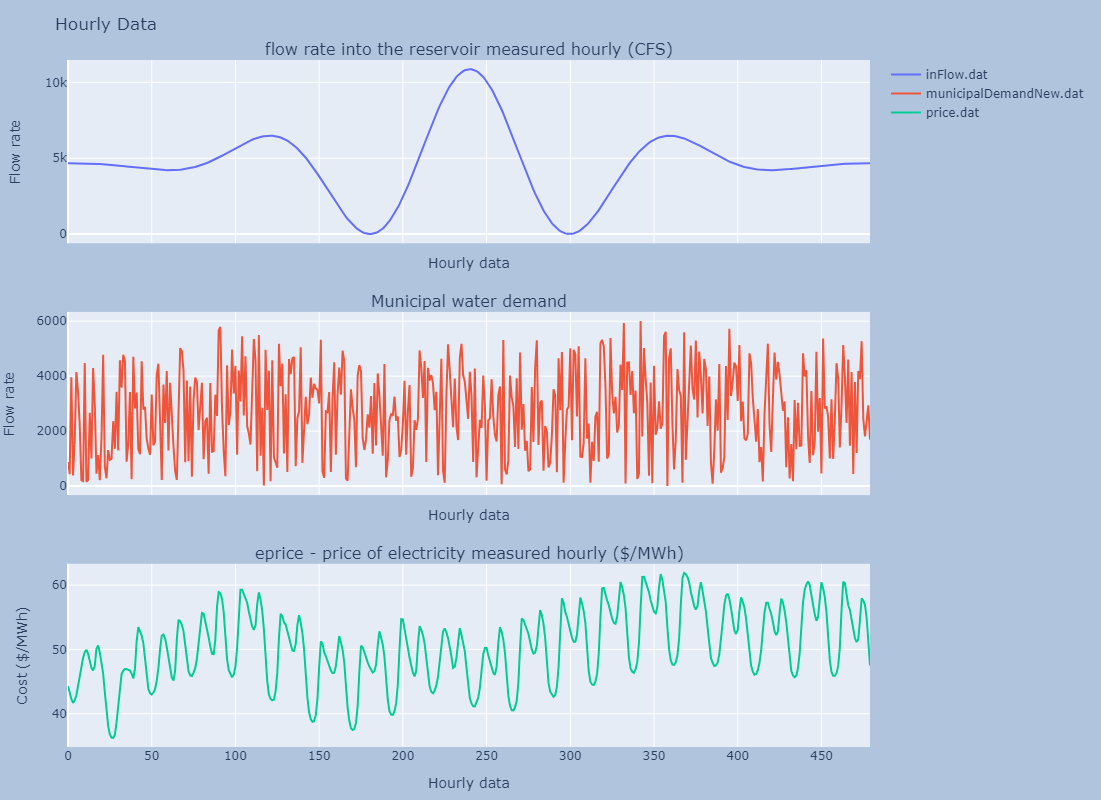

In [2]:
#list comprehension for storing all of the files in the folder
folder_path = "/Users/amaleki1/Desktop/Delft_material/Optimization reserach skills/RSOPT_Assignment_JoostVerbart/RSOPT_Assignment_JoostVerbart"
file_list = [file for file in
             os.listdir("/Users/amaleki1/Desktop/Delft_material/Optimization reserach skills/RSOPT_Assignment_JoostVerbart/RSOPT_Assignment_JoostVerbart")
             if file.endswith('.dat')]
len(file_list)


#creating a dictionary to store different dataset
data_arrays = {}

# Loop through the files and read their contents
for i, file_name in enumerate(file_list):
    file_path = os.path.join(folder_path, file_name)
    with open(file_path, 'r') as file:
        content = file.readlines()
        content = [float(line.strip()) for line in content]  # Assuming data is numeric
        data_arrays[file_name] = np.array(content)

# Create subplots
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=("flow rate into the reservoir measured hourly (CFS)",
                                                                      "Municipal water demand",
                                                                      "eprice - price of electricity measured hourly ($/MWh)"),
                                                                      vertical_spacing=0.1)

# Loop through the files and add traces to the subplots
for i, file_name in enumerate(file_list, start=1):
    file_path = os.path.join(folder_path, file_name)
    with open(file_path, 'r') as file:
        content = file.readlines()
        content = [float(line.strip()) for line in content]  # Assuming data is numeric
        # Add trace to subplot
        fig.add_trace(go.Scatter(x=list(range(len(content))), y=content, mode='lines', name=file_name), row=i, col=1)

# Update axes labels
fig.update_xaxes(title_text="Hourly data", row=1, col=1)
fig.update_yaxes(title_text="Flow rate", row=1, col=1)
fig.update_xaxes(title_text="Hourly data", row=2, col=1)
fig.update_yaxes(title_text="Flow rate", row=2, col=1)
fig.update_xaxes(title_text="Hourly data", row=3, col=1)
fig.update_yaxes(title_text="Cost ($/MWh)", row=3, col=1)

# Update subplot titles
fig.update_layout(title_text="Hourly Data")
# Adjust the horizontal spacing between subplots to increase their width
fig.update_layout(height=800, width=800, margin=dict(l=40, r=40, t=60, b=40),  # Adjust margins as needed
                  paper_bgcolor="LightSteelBlue",  # Set background color
                  )

# Show the plot
fig.show()



In [3]:
# Storing the data for the flow of turbine
inflow_reservoir = data_arrays['inFlow.dat'].tolist()
municipal_demand = data_arrays['municipalDemandNew.dat'].tolist()
price = data_arrays['price.dat'].tolist()
N = len(inflow_reservoir) - 1

# Converting lists to dictionaries to be used in pyomo later on
inflow_reservoir = {index: value for index, value in enumerate(inflow_reservoir)}
municipal_demand = {index: value for index, value in enumerate(municipal_demand)}
price = {index : value for index, value in enumerate(price)}

# Defining the constants
k1 = 0.00003
k2 = 9

#MW to kW
MW2kW = 1000

#Convert from CFS to AF/HR
C2A = 1.98347 / 24

#setting initial storage
#storage is in AF
initial_storage = 90000
final_volume = initial_storage

#upper and lower bound for Turbin
Turbin_lb = 0
Turbin_ub = 10000

#upper and lower bound for storage
#storage is in AF
storage_lb = 50000
storage_ub = 100000

#max change in two consequtive time step in turbin and spillway
max_change_turbin = 500
max_change_spill = 500

#minimum summation of spill and turbin
combine_spill_turbin = 1000

# Maximize Electricity Generation

The objective is to maximize the total revenue from electricity generation over the prediction horizon:

$$
\text{maximize} \sum_{t=1}^{N} \frac{\text{TurbineFlow}_t}{1} \left(0.5 \cdot k1 \cdot \left(\text{ReservoirStorage}_t + \text{ReservoirStorage}_{t-1}\right) + k2\right)
$$

## Constraints

### Reservoir Storage Dynamics

$$
\text{ReservoirStorage}_{t} = \text{ReservoirStorage}_{t-1} + C2A \cdot \left(\text{inFlow}_{t-1} - \text{TurbineFlow}_{t-1} - \text{SpillFlow}_{t-1}\right) \quad \text{for } t = 1, 2, \ldots, N
$$

### Combined Turbine and Spill Flow

$$
\text{TurbineFlow}_t + \text{SpillFlow}_t \geq 1000, \quad \text{for } t = 1, 2, \ldots, N
$$

### change in Turbine flow

$$
 -500 \leq \text{TurbineFlow}_t + \text{TurbineFlow}_{t-1} \leq 500 , \quad \text{for } t = 1, 2, \ldots, N
$$

### change in spill flow 

$$
-500 \leq \text{SpillFlow}_t + \text{SpillFlow}_{t-1} \leq 500, \quad \text{for } t = 1, 2, \ldots, N
$$

### Initial Reservoir Storage

$$
\text{ReservoirStorage}_N = \text{ReservoirStorage}_0 
$$



## Constants

| Variable       | Description                                       |
|----------------|---------------------------------------------------|
| inFlow_t       | Flow rate into the reservoir at time \(t\) (CFS)  |
| epricei_t     | Electricity price at time \(t\) (\$/MWh)          |
| muni_demand   | Municipal water demand at time \(t\) (CFS)        |
| TurbineFlow   | Flow rate through the turbine                     |
  | Flow rate through the turbine                     |


## what is ipopt?
IPOPT is particularly useful for solving nonlinear optimization problems with continuous variables and constraints. It employs an interior-point algorithm to iteratively find solutions that satisfy both the problem constraints and the optimality conditions.

In [5]:
#Create an abstract model
model = AbstractModel()

# Define the range set for time
model.Time = RangeSet(0, N)

# Define parameters
model.inFlow = Param(model.Time , initialize = inflow_reservoir,mutable = False) #Not mutable since they are provided time series
model.eprice = Param(model.Time , initialize = price,mutable = False) #Not mutable since they are provided time series
model.muni_demand = Param(model.Time , initialize = municipal_demand,mutable = False) #Not mutable since they are provided time series

# Define constants as parameters and they are constant based on the provided data
model.k1 = Param(initialize = k1, mutable=False)
model.k2 = Param(initialize =k2, mutable=False)
model.MW2kW = Param(initialize =MW2kW, mutable=False)
model.C2A = Param(initialize =C2A , mutable=False)
model.InitialStorage = Param(initialize =initial_storage,mutable = False)

# Define decision variables

# Turbin flow is confined from 0 to 10000
model.TurbineFlow = Var(model.Time, within=NonNegativeReals, bounds=(Turbin_lb, Turbin_ub), initialize = 0)

#Spill flow needs to be possitive
model.SpillFlow = Var(model.Time, within=NonNegativeReals, bounds = (0, None), initialize = 0)

#defining the storage size
model.ReservoirStorage = Var(model.Time, bounds=(storage_lb,storage_ub))


#Defining the objective function
def Profit(model):
    '''
    This function calculates the electricity production based on  the reservoir storage level.
    '''
    def ElectricityProduction(t):
        if t==0: 
            return 0
        else:
            return model.TurbineFlow[t-1] * (0.5 * model.k1 * (model.ReservoirStorage[t] + model.ReservoirStorage[t-1]) + model.k2)
    return sum([ElectricityProduction(i) for i in model.Time])
model.obj = Objective(rule=Profit, sense=maximize)



# Define derived variable and associated constraint
def reservoir_storage_rule(model, t):
    '''
    This function is used for calculating the storage level based on turbine flow, spill flow and inflow
    '''
    if t == 0:
        return model.ReservoirStorage[t] == initial_storage
    return model.ReservoirStorage[t] == model.ReservoirStorage[t-1] + model.C2A * (model.inFlow[t-1] - model.TurbineFlow[t-1] - model.SpillFlow[t-1])
model.ReservoirStorageConstraint = Constraint(model.Time, rule=reservoir_storage_rule)

# Define the constraint related to changing the spill flow at each time step for positive 500
def change_SpillFlow(model, t):
    if t == 0:
        return Constraint.Skip  # Skip the first time period as there is no previous time period
    else:
        return model.SpillFlow[t] - model.SpillFlow[t-1] <= max_change_turbin
model.change_flow_change_SpillFlow = Constraint(model.Time, rule=change_SpillFlow)

# Define the constraint related to changing the spill flow at each time step for minus 500
def change_SpillFlow_minus(model, t):
    if t == 0:
        return Constraint.Skip  # Skip the first time period as there is no previous time period
    else:
        return model.SpillFlow[t] - model.SpillFlow[t-1] >= -max_change_turbin

model.change_flow_change_SpillFlow_1 = Constraint(model.Time, rule=change_SpillFlow_minus)


# Define the constraint related to changing the turbine flow at each time step for positive 500
def change_TurbineFlow(model, t):
    if t == 0:
        return Constraint.Skip  # Skip the first time period as there is no previous time period
    else:
        return (model.TurbineFlow[t] - model.TurbineFlow[t-1]) <= max_change_turbin

model.change_flow_change_TurbineFlow = Constraint(model.Time, rule=change_TurbineFlow)

# Define the constraint related to changing the turbine flow at each time step for minus 500
def change_TurbineFlow_minus(model, t):
    if t == 0:
        return Constraint.Skip  # Skip the first time period as there is no previous time period
    else:
        return (model.TurbineFlow[t] - model.TurbineFlow[t-1]) >= -max_change_turbin

model.change_flow_change_TurbineFlow_1 = Constraint(model.Time, rule=change_TurbineFlow_minus)


#To satisfy minimum flow
def min_flow_change_rule(model, t):
    '''
    Defining the minimum spill and turbin flow at each time step
    '''
    return model.TurbineFlow[t] + model.SpillFlow[t] >= combine_spill_turbin
model.CombinedTurbinSpills = Constraint(model.Time, rule=min_flow_change_rule)


# Set initial and final reservoir storage constraints
def initial_reservoir_storage_rule(model):
    '''
    Setting initial storage in reservoir'''
    return model.ReservoirStorage[0] - model.ReservoirStorage[N]  <= 10e-8
model.InitialReservoirStorage = Constraint(rule=initial_reservoir_storage_rule)

# Solve the model for the optimal storage size
instance = model.create_instance()
solver = SolverFactory('ipopt') # IPOPT, which is suitable for this type of nonlinear problem. 
results_electricity = solver.solve(instance)
objective_values = []

# Check the solver status
if results_electricity.solver.termination_condition == TerminationCondition.optimal:
    print('Optimization successful for optimal initial storage.')
    optimal_objective_value = instance.obj()
    optimal_turbine_flow_ex1_1 = [value(instance.TurbineFlow[t]) for t in instance.Time]
    optimal_spill_flow_ex1_1 = [value(instance.SpillFlow[t]) for t in instance.Time]
    optimal_storage_level_ex1_1 = [value(instance.ReservoirStorage[t]) for t in instance.Time]
else:
    print("Solver did not converge to an optimal solution.")

Optimization successful for optimal initial storage.


## showing the result

Optimization successful for optimal initial storage.


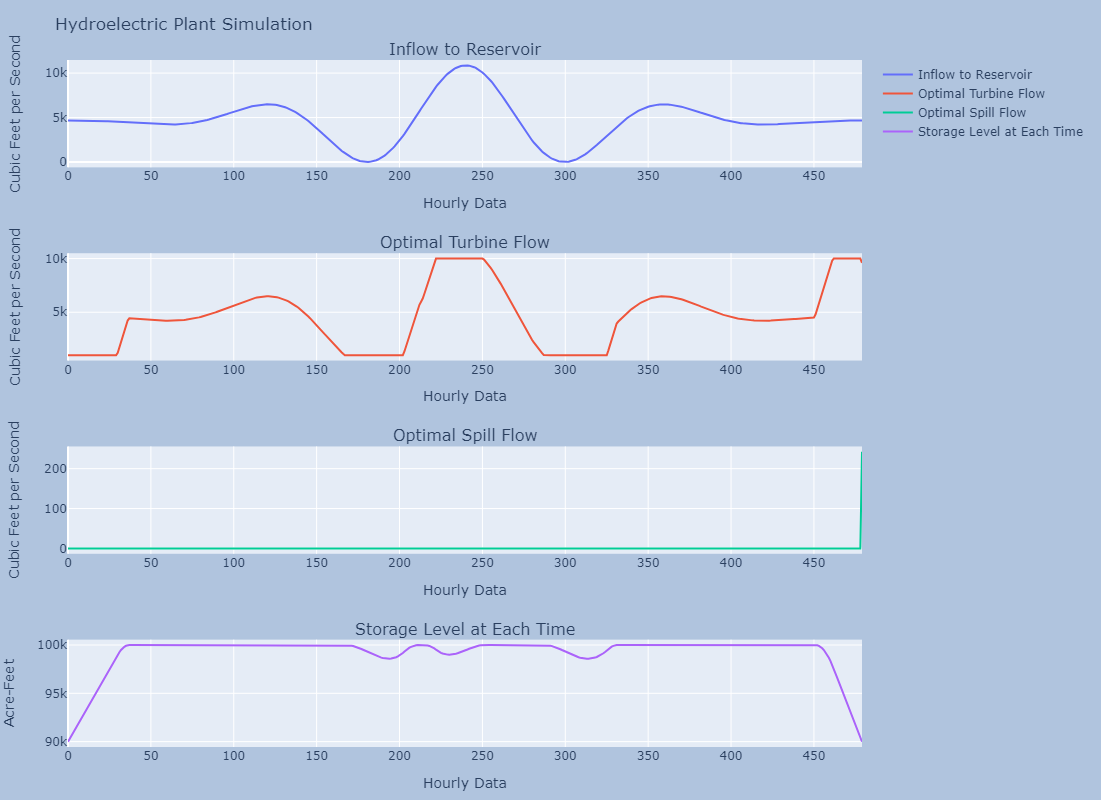

In [6]:
# Solve the model for the optimal storage size
instance = model.create_instance()
solver = SolverFactory('ipopt')
results_electricity = solver.solve(instance)

# Check the solver status
if results_electricity.solver.termination_condition == TerminationCondition.optimal:
    print('Optimization successful for optimal initial storage.')
    optimal_turbine_flow_ex1_1 = [value(instance.TurbineFlow[t]) for t in instance.Time]
    optimal_spill_flow_ex1_1 = [value(instance.SpillFlow[t]) for t in instance.Time]
    optimal_storage_level_ex1_1 = [value(instance.ReservoirStorage[t]) for t in instance.Time]
else:
    print("Solver did not converge to an optimal solution.")



# Create subplots
fig = make_subplots(rows=4, cols=1, subplot_titles=("Inflow to Reservoir", "Optimal Turbine Flow", "Optimal Spill Flow", "Storage Level at Each Time"))

# Add traces to subplots
fig.add_trace(go.Scatter(x=list(range(len(inflow_reservoir))), y=list(inflow_reservoir.values()), mode='lines', name='Inflow to Reservoir'), row=1, col=1)
fig.add_trace(go.Scatter(x=list(range(len(optimal_turbine_flow_ex1_1))), y=optimal_turbine_flow_ex1_1, mode='lines', name='Optimal Turbine Flow'), row=2, col=1)
fig.add_trace(go.Scatter(x=list(range(len(optimal_spill_flow_ex1_1))), y=optimal_spill_flow_ex1_1, mode='lines', name='Optimal Spill Flow'), row=3, col=1)
fig.add_trace(go.Scatter(x=list(range(len(optimal_storage_level_ex1_1))), y=optimal_storage_level_ex1_1, mode='lines', name='Storage Level at Each Time'), row=4, col=1)

# Update layout
fig.update_layout(title='Hydroelectric Plant Simulation', height=800, width=1000)

# Update x-axis and y-axis titles for all subplots
fig.update_xaxes(title_text='Hourly Data', row=1, col=1)
fig.update_xaxes(title_text='Hourly Data', row=2, col=1)
fig.update_xaxes(title_text='Hourly Data', row=3, col=1)
fig.update_xaxes(title_text='Hourly Data', row=4, col=1)

fig.update_yaxes(title_text='Cubic Feet per Second', row=1, col=1)
fig.update_yaxes(title_text='Cubic Feet per Second', row=2, col=1)
fig.update_yaxes(title_text='Cubic Feet per Second', row=3, col=1)
fig.update_yaxes(title_text='Acre-Feet', row=4, col=1)

# Adjust the horizontal spacing between subplots to increase their width
fig.update_layout(margin=dict(l=40, r=40, t=60, b=40),  # Adjust margins as needed
                  paper_bgcolor="LightSteelBlue",  # Set background color
                  )

# Show plot
fig.show()



In [7]:
#To calculate how much energy produced with optimal turbine flow
Electricity = []
Storage = []
Q_turbine = []
Q_spill = []

def En(Q, S1, S2):
    '''
    Calculating the electricity produced from the optimal turbine flow in exe 1
    '''
    k1 = 0.00003
    k2 = 9.0
    return Q * (0.5 * k1 *(S1 + S2) + k2) 

for i in instance.Time:
    Storage.append(instance.ReservoirStorage[i].value)
    Q_turbine.append(instance.TurbineFlow[i].value)
    Q_spill.append(instance.SpillFlow[i].value)
    if i!=0:
        Electricity.append(En(Q_turbine[i-1], Storage[i-1], Storage[i]))
    else:
        Electricity.append(0)


In [8]:
baseload = sum(Electricity)/len(Electricity) 
print(f'the based is {baseload} KW')
#minimum/time steps

the based is 55192.478447725174 KW


## EX1 result interpretation by Arash
<span style="color:red">Because the goal is to maximize electrical production while keeping the minimum and maximum storage sizes in mind, the turbine flow is kept as high as possible while the spill flow is kept as low as possible. The spill flow adjusts in the final time step to meet the constraint of having the storage volume at the initial and final time steps.</span>
 }

# Changing the objective function for EX1 part 2

# Maximize Total Revenue from Electricity Generation


The objective is to maximize the total revenue from electricity generation over the prediction horizon:

$$
\sum_{{t=1}}^{N} \frac{{\text{eprice}_{t} \cdot \text{TurbineFlow}_t}}{MW2KW} \left(0.5 \cdot k1 \cdot \left(\text{ReservoirStorage}_t + \text{ReservoirStorage}_{t-1}\right) + k2\right)
$$

## Constraints

### Reservoir Storage Dynamics

$$
\text{ReservoirStorage}_{t} = \text{ReservoirStorage}_{t-1} + C2A \cdot \left(\text{inFlow}_{t-1} - \text{TurbineFlow}_{t-1} - \text{SpillFlow}_{t-1}\right) \quad \text{for } t = 1, 2, \ldots, N
$$

### Combined Turbine and Spill Flow

$$
\text{TurbineFlow}_t + \text{SpillFlow}_t \geq 1000, \quad \text{for } t = 1, 2, \ldots, N
$$

### change in Turbine flow

$$
 -500 \leq \text{TurbineFlow}_t + \text{TurbineFlow}_{t-1} \leq 500 , \quad \text{for } t = 1, 2, \ldots, N
$$

### change in spill flow 

$$
-500 \leq \text{SpillFlow}_t + \text{SpillFlow}_{t-1} \leq 500, \quad \text{for } t = 1, 2, \ldots, N
$$

### Initial Reservoir Storage

$$
\text{ReservoirStorage}_N = \text{ReservoirStorage}_0  
$$



## Constants

| Variable       | Description                                       |
|----------------|---------------------------------------------------|
| inFlow_t       | Flow rate into the reservoir at time \(t\) (CFS)  |
| epricei_t     | Electricity price at time \(t\) (\$/MWh)          |
| muni_demand   | Municipal water demand at time \(t\) (CFS)        |
| TurbineFlow   | Flow rate through the turbine                     |





In [9]:
# Replace the old objective with the new one
model.del_component(model.obj)  # Delete the old objective

def Profit(model):
    def ElectricityProduction(t):
        if t==0:
            return 0
        else:
            return model.TurbineFlow[t-1] * (0.5 * k1 * (model.ReservoirStorage[t] + model.ReservoirStorage[t-1]) + k2) / 1000
    return sum([model.eprice[i] * ElectricityProduction(i) for i in model.Time])
    
model.obj = Objective(rule=Profit, sense=maximize)  # Assign the new objective

# Create a new instance of the modified model
instance = model.create_instance()

# Solve the optimization problem
solver = SolverFactory('ipopt')
results = solver.solve(instance)

# Get the objective value
obj_value = value(instance.obj)



The optimization has been successful and optimum variables have been stored


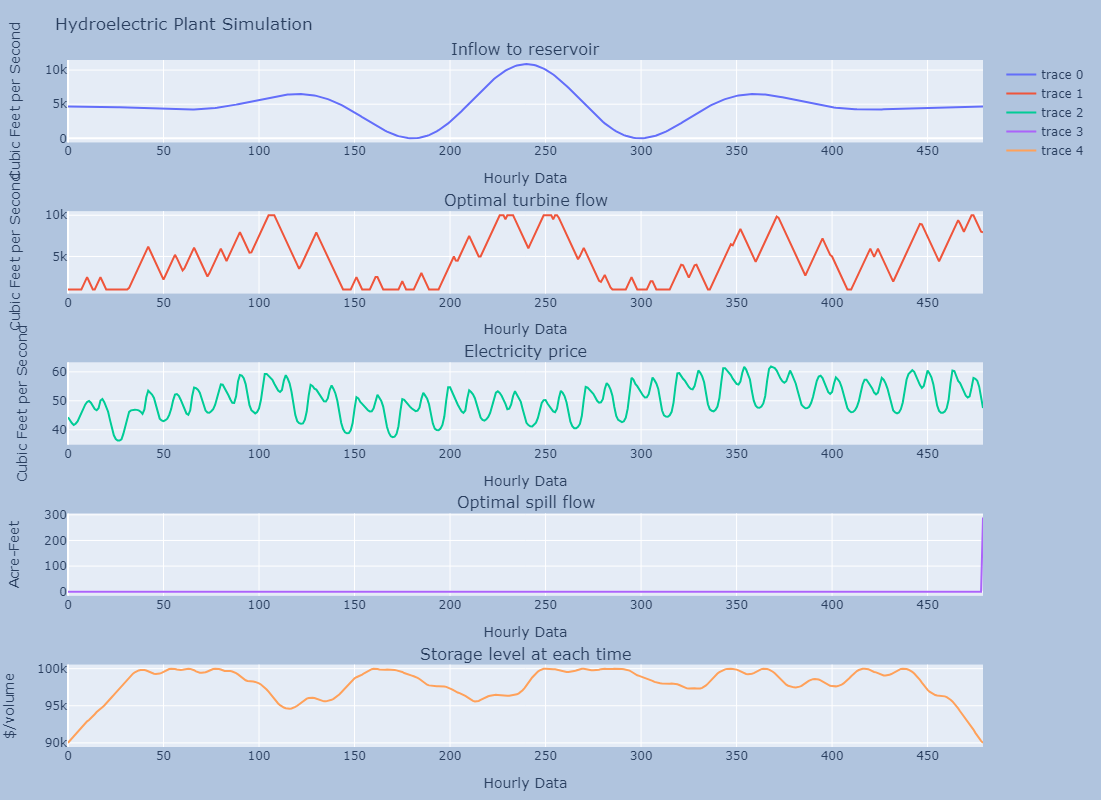

In [10]:
# Check the solver status
if results.solver.termination_condition == TerminationCondition.optimal:
    print('The optimization has been successful and optimum variables have been stored')
    
    # Access the optimal values
    optimal_turbine_flow_ex1_2 = [value(instance.TurbineFlow[t]) for t in instance.Time]
    optimal_spill_flow_ex1_2 = [value(instance.SpillFlow[t]) for t in instance.Time]
    optimal_storage_level_ex1_2 = [value(instance.ReservoirStorage[t]) for t in instance.Time]

    # Create a subplot with 5 rows and 1 column
    fig = make_subplots(rows=5, cols=1, subplot_titles=("Inflow to reservoir", "Optimal turbine flow", "Electricity price", "Optimal spill flow", "Storage level at each time"))

    # Plot on each subplot
    fig.add_trace(go.Scatter(x=list(inflow_reservoir.keys()), y=list(inflow_reservoir.values()), mode='lines'), row=1, col=1)
    fig.add_trace(go.Scatter(x=list(range(len(optimal_turbine_flow_ex1_2))), y=optimal_turbine_flow_ex1_2, mode='lines'), row=2, col=1)
    fig.add_trace(go.Scatter(x=list(price.keys()), y=list(price.values()), mode='lines'), row=3, col=1)
    fig.add_trace(go.Scatter(x=list(range(len(optimal_spill_flow_ex1_2))), y=optimal_spill_flow_ex1_2, mode='lines'), row=4, col=1)
    fig.add_trace(go.Scatter(x=list(range(len(optimal_storage_level_ex1_2))), y=optimal_storage_level_ex1_2, mode='lines'), row=5, col=1)

    # Set subplot titles
    fig.update_xaxes(title_text='Hourly Data', row=1, col=1)
    fig.update_xaxes(title_text='Hourly Data', row=2, col=1)
    fig.update_xaxes(title_text='Hourly Data', row=3, col=1)
    fig.update_xaxes(title_text='Hourly Data', row=4, col=1)
    fig.update_xaxes(title_text='Hourly Data', row=5, col=1)
    fig.update_yaxes(title_text='Cubic Feet per Second', row=1, col=1)
    fig.update_yaxes(title_text='Cubic Feet per Second', row=2, col=1)
    fig.update_yaxes(title_text='Cubic Feet per Second', row=3, col=1)
    fig.update_yaxes(title_text='Acre-Feet', row=4, col=1)
    fig.update_yaxes(title_text='$/volume', row=5, col=1)

    # Adjust the horizontal spacing between subplots to increase their width
    fig.update_layout(margin=dict(l=40, r=40, t=60, b=40),  # Adjust margins as needed
                  paper_bgcolor="LightSteelBlue",  # Set background color
                  )

    # Update subplot titles
    fig.update_layout(title='Hydroelectric Plant Simulation', height=800, width=1000)
    
    # Show the plot
    fig.show()

    
else:
    print("Solver did not converge to an optimal solution.")

### Comment about the above graph
in the last time step, there is spill flow for bringing back the storage level to the initial one (one of the constraints)

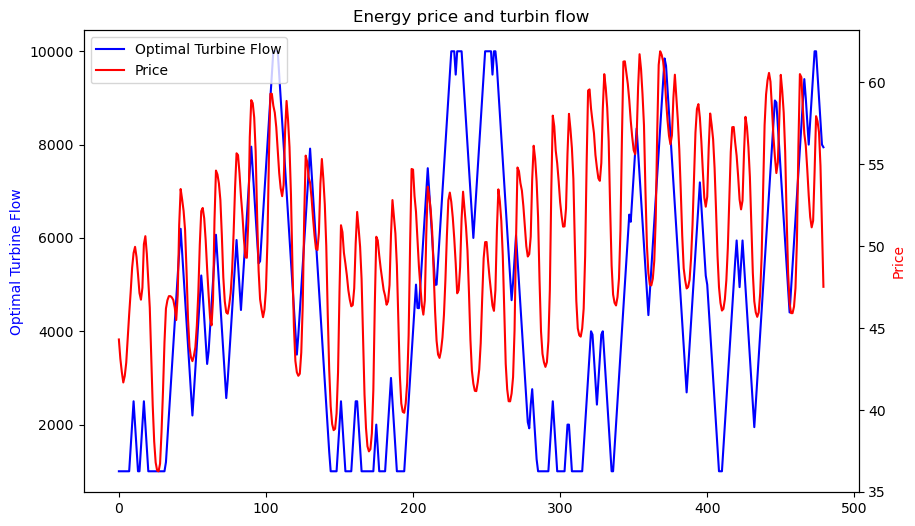

In [10]:
# Create figure and axis objects with a larger size
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Optimal Turbine Flow on the first y-axis
ax1.plot(range(len(optimal_turbine_flow_ex1_2)), optimal_turbine_flow_ex1_2, color='b', label='Optimal Turbine Flow')
ax1.set_ylabel('Optimal Turbine Flow', color='b')

# Create a second y-axis
ax2 = ax1.twinx()

# Plot Price on the second y-axis
ax2.plot(list(price.keys()), list(price.values()), color='r', label='Price')
ax2.set_ylabel('Price', color='r')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Set x-axis label
plt.xlabel('Time step')

# Set plot title
plt.title('Energy price and turbin flow')

# Show plot
plt.show()

### Comment about the above graph

<span style="color:red">There is high correlation between the price of the energy and the turbine flow. when the price is higher there is a tendency to release more water through the turbine flow for electricity production</span>


## Exercise 2: Energy production with a baseload guarantee

In the above exercises, we have considered no baseload energy servicing. However, this may result in reservoir operations that are opportunistic. Now consider a service reservoir that has to satisfy also a baseload of power.  

1. Assume the baseload is 50% of the average of the power produced in your optimal solution for Exercise 1. (If this baseload is not feasible to supply, use a lower fraction of the average power).

    *Repeat the energy and revenue optimisation as in Exercise 1 and with the baseload constraint. Discuss the results.
    
    

2. Assume the baseload is the average of the power produced in your optimal solution for Exercise 1. Now assume the economic cost of not meeting the baselaod demand is much higher than the energy price; therefore, formulate the problem of minimising the unmet baseload demand. Discuss the results. 



## Solving the first one
1. Assume the baseload is 50% of the average of the power produced in your optimal solution for Exercise 1. (If this baseload is not feasible to supply, use a lower fraction of the average power).

    *Repeat the energy and revenue optimisation as in Exercise 1 and with the baseload constraint. Discuss the results.

### Added part by Arash
The revenue constraint per time step is formulated as follows:$$
electricity_{t} = baseload
$$e.
s time step.


In [11]:
def MeetingDemandEachTimestep(model, t):
    ''' 
    This function guarantees that at every timestep the baseload is supplied
    '''
    if t == 0:
        return Constraint.Skip  # Skip for the initial time step, or handle it according to your model's specifics
    else :
        return (model.TurbineFlow[t] * model.C2A) * (
        0.5 * model.k1 * (model.ReservoirStorage[t] + model.ReservoirStorage[t-1]) + model.k2) >= baseload_applied


model.ElectricityDemandEachTime = Constraint(model.Time, rule=MeetingDemandEachTimestep)

In [12]:
# based on trial error performed it was concluded that 8% of the baseload is possible to be satisfied
baseload_applied= 0.08 * baseload
print(f'baseload is {baseload_applied}')

# Create the instance
instance = model.create_instance()

# Solve the optimization problem
solver = SolverFactory('ipopt')
results_electricity = solver.solve(instance)

# Get the objective value
obj_value_case1 = value(instance.obj)


baseload is 4415.398275818014


The optimization has been successful and optimum variables have been stored


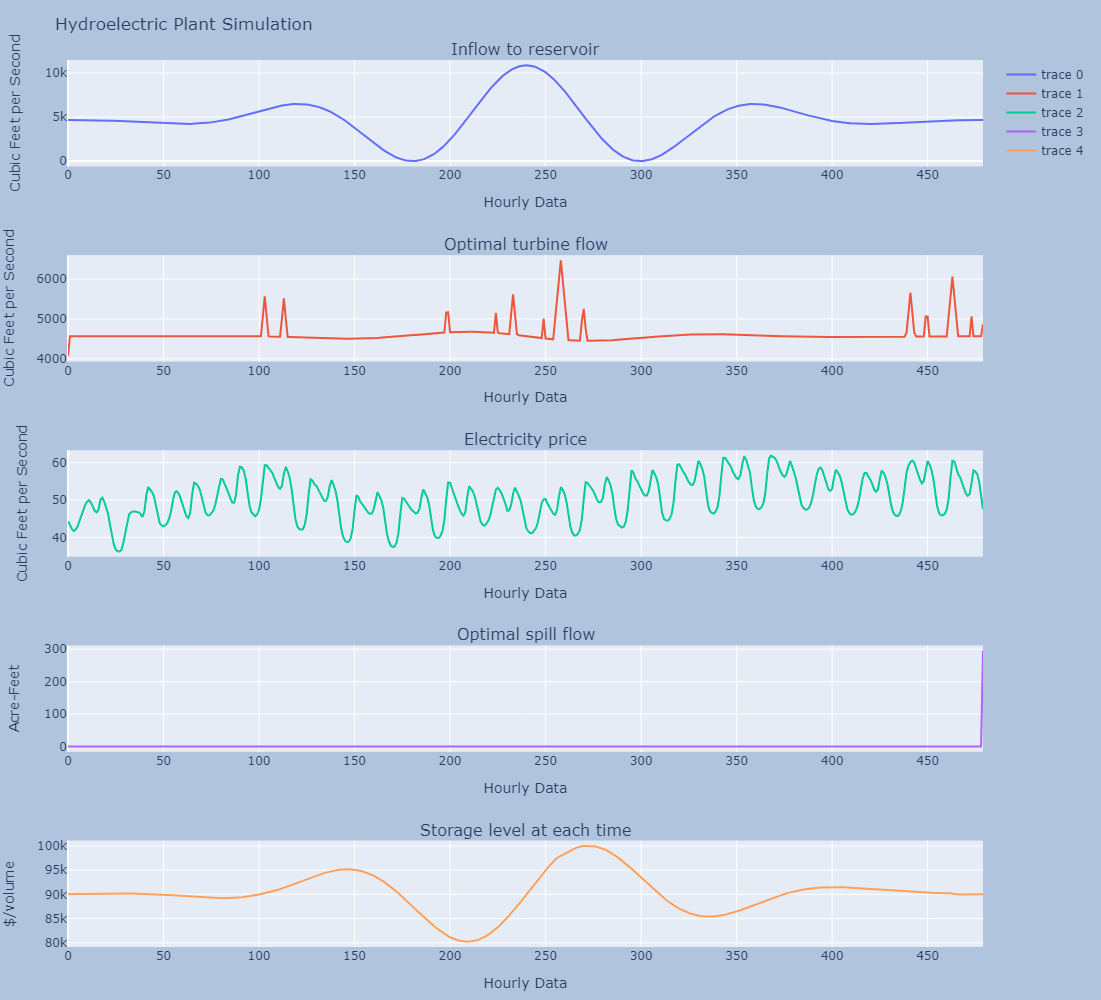

In [13]:
# Check the solver status
if results_electricity.solver.termination_condition == TerminationCondition.optimal:
    print('The optimization has been successful and optimum variables have been stored')

    # Access the optimal values
    optimal_turbine_flow_ex2_1 = [value(instance.TurbineFlow[t]) for t in instance.Time]
    optimal_spill_flow_ex2_1 = [value(instance.SpillFlow[t]) for t in instance.Time]
    optimal_storage_level_ex2_1 = [value(instance.ReservoirStorage[t]) for t in instance.Time]

    # Create a subplot with 5 rows and 1 column
    fig = make_subplots(rows=5, cols=1, subplot_titles=("Inflow to reservoir", "Optimal turbine flow","Electricity price", "Optimal spill flow", "Storage level at each time"))

    # Plot on each subplot
    fig.add_trace(go.Scatter(x=list(inflow_reservoir.keys()), y=list(inflow_reservoir.values()), mode='lines'), row=1, col=1)
    fig.add_trace(go.Scatter(x=list(range(len(optimal_turbine_flow_ex2_1))), y=optimal_turbine_flow_ex2_1, mode='lines'), row=2, col=1)
    fig.add_trace(go.Scatter(x=list(price.keys()), y=list(price.values()), mode='lines'), row=3, col=1)
    fig.add_trace(go.Scatter(x=list(range(len(optimal_spill_flow_ex2_1))), y=optimal_spill_flow_ex2_1, mode='lines'), row=4, col=1)
    fig.add_trace(go.Scatter(x=list(range(len(optimal_storage_level_ex2_1))), y=optimal_storage_level_ex2_1, mode='lines'), row=5, col=1)

    # Set subplot titles
    fig.update_xaxes(title_text='Hourly Data', row=1, col=1)
    fig.update_xaxes(title_text='Hourly Data', row=2, col=1)
    fig.update_xaxes(title_text='Hourly Data', row=3, col=1)
    fig.update_xaxes(title_text='Hourly Data', row=4, col=1)
    fig.update_xaxes(title_text='Hourly Data', row=5, col=1)

    fig.update_yaxes(title_text='Cubic Feet per Second', row=1, col=1)
    fig.update_yaxes(title_text='Cubic Feet per Second', row=2, col=1)
    fig.update_yaxes(title_text='Cubic Feet per Second', row=3, col=1)
    fig.update_yaxes(title_text='Acre-Feet', row=4, col=1)
    fig.update_yaxes(title_text='$/volume', row=5, col=1)
    # Adjust the horizontal spacing between subplots to increase their width
    fig.update_layout(margin=dict(l=40, r=40, t=60, b=40),  # Adjust margins as needed
                  paper_bgcolor="LightSteelBlue",  # Set background color
                  )

    # Update subplot titles
    fig.update_layout(title='Hydroelectric Plant Simulation', height=1000, width=1000)

    # Show the plot
    fig.show()
    
else:
    print("Solver did not converge to an optimal solution.")

## EX1 result interpretation by Arash
The turbine flow always satifies the minimum imposed by the constratint about meeting the minimum energy production at each time step

## solving exercise 2
2. Assume the baseload is the average of the power produced in your optimal solution for Exercise 1. Now assume the economic cost of not meeting the baselaod demand is much higher than the energy price; therefore, formulate the problem of minimising the unmet baseload demand. Discuss the results. 


In [17]:
# Replace the old objective with the new one
model.del_component(model.obj)  # Delete the old objective


In [18]:
def UnmetDemandObj(model):
    '''
    This function tries to minimize the unmet demand by considering the produced electricity and the baseload demand
    '''
    def Unmetdemand(t):
        if t==0:
            return 0
        else:
            return  (100 * ((model.TurbineFlow[t] * 0.5 * model.k1 * (model.ReservoirStorage[t] + model.ReservoirStorage[t-1])
                     + model.k2) - baseload_applied)/ baseload_applied) ** 2
    return sum([Unmetdemand(i) for i in model.Time])
model.obj = Objective(rule=UnmetDemandObj, sense=minimize)


In [19]:
# Create the instance
instance = model.create_instance()

# Solve the optimization problem
solver = SolverFactory('ipopt')
results = solver.solve(instance)

# Check if the solver successfully solved the problem
if results.solver.status == SolverStatus.ok and results.solver.termination_condition == TerminationCondition.optimal:
    # Get the objective value
    obj_value = value(instance.obj)
    print(f"The objective function value is: {obj_value}")
else:
    print("Solver did not return optimal solution status.")




The objective function value is: 15104619.232469244


The optimization has been successful and optimum variables have been stored


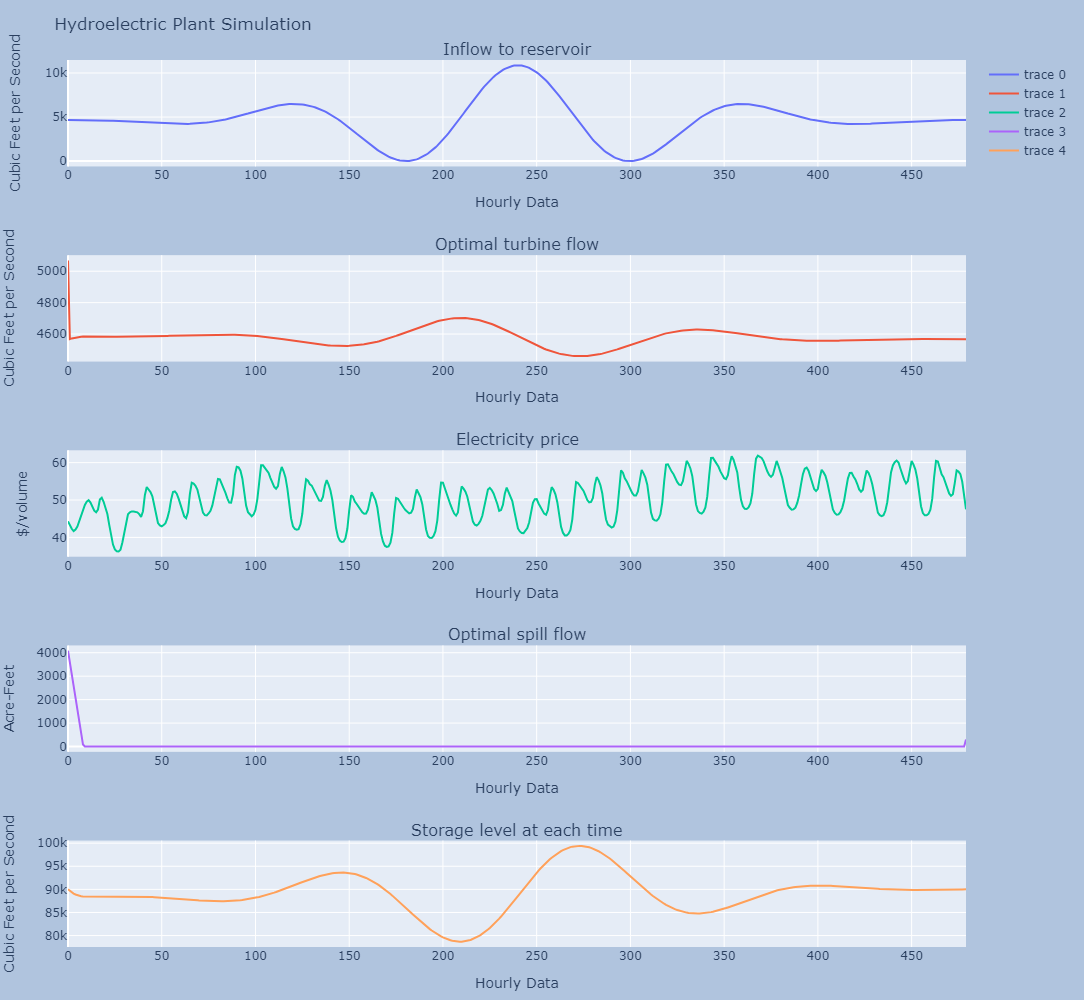

In [20]:
# Check the solver status
if results_electricity.solver.termination_condition == TerminationCondition.optimal:
    print('The optimization has been successful and optimum variables have been stored')

    # Access the optimal values
    optimal_turbine_flow_ex2_2 = [value(instance.TurbineFlow[t]) for t in instance.Time]
    optimal_spill_flow_ex2_2 = [value(instance.SpillFlow[t]) for t in instance.Time]
    optimal_storage_level_ex2_2 = [value(instance.ReservoirStorage[t]) for t in instance.Time]

    # Create a subplot with 5 rows and 1 column
    fig = make_subplots(rows=5, cols=1, subplot_titles=("Inflow to reservoir", "Optimal turbine flow","Electricity price", "Optimal spill flow", "Storage level at each time"))

    # Plot on each subplot
    fig.add_trace(go.Scatter(x=list(inflow_reservoir.keys()), y=list(inflow_reservoir.values()), mode='lines'), row=1, col=1)
    fig.add_trace(go.Scatter(x=list(range(len(optimal_turbine_flow_ex2_1))), y=optimal_turbine_flow_ex2_2, mode='lines'), row=2, col=1)
    fig.add_trace(go.Scatter(x=list(price.keys()), y=list(price.values()), mode='lines'), row=3, col=1)
    fig.add_trace(go.Scatter(x=list(range(len(optimal_spill_flow_ex2_1))), y=optimal_spill_flow_ex2_2, mode='lines'), row=4, col=1)
    fig.add_trace(go.Scatter(x=list(range(len(optimal_storage_level_ex2_1))), y=optimal_storage_level_ex2_2, mode='lines'), row=5, col=1)

    # Set subplot titles
    fig.update_xaxes(title_text='Hourly Data', row=1, col=1)
    fig.update_xaxes(title_text='Hourly Data', row=2, col=1)
    fig.update_xaxes(title_text='Hourly Data', row=3, col=1)
    fig.update_xaxes(title_text='Hourly Data', row=4, col=1)
    fig.update_xaxes(title_text='Hourly Data', row=5, col=1)

    fig.update_yaxes(title_text='Cubic Feet per Second', row=1, col=1)
    fig.update_yaxes(title_text='Cubic Feet per Second', row=2, col=1)
    fig.update_yaxes(title_text='Cubic Feet per Second', row=5, col=1)
    fig.update_yaxes(title_text='Acre-Feet', row=4, col=1)
    fig.update_yaxes(title_text='$/volume', row=3, col=1)
    
    # Adjust the horizontal spacing between subplots to increase their width
    fig.update_layout(margin=dict(l=40, r=40, t=60, b=40),  # Adjust margins as needed
                  paper_bgcolor="LightSteelBlue",  # Set background color
                  )
    # Update subplot titles
    fig.update_layout(title='Hydroelectric Plant Simulation', height=1000, width=1000)

    # Show the plot
    fig.show()
    
else:
    print("Solver did not converge to an optimal solution.")

## comparison of the flows from the two exercises regarding the turbin flow

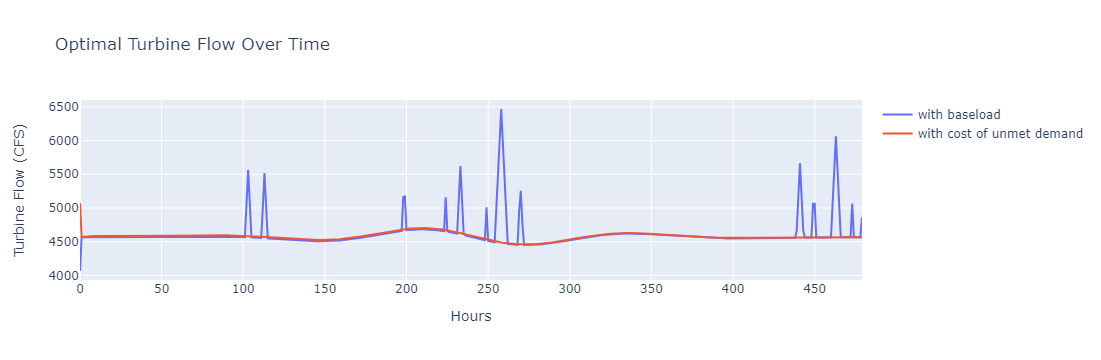

In [21]:
# Create traces for each list
trace1 = go.Scatter(x=np.arange(0,len(optimal_turbine_flow_ex2_2),1), y=optimal_turbine_flow_ex2_1, mode='lines', name='with baseload')
trace2 = go.Scatter(x=np.arange(0,len(optimal_turbine_flow_ex2_2),1), y=optimal_turbine_flow_ex2_2, mode='lines', name='with cost of unmet demand')

# Create a figure and add traces
fig = go.Figure()
fig.add_trace(trace1)
fig.add_trace(trace2)

# Update layout
fig.update_layout(title='Optimal Turbine Flow Over Time',
                  xaxis_title='Hours',
                  yaxis_title='Turbine Flow (CFS)')

# Show the plot
fig.show()

## comment about the above graph
Turbine flow is much smoother in minimizing the unmet demand and just satisfying the demand. Also the release does not consider the price of electricity.


## Exercise 3
    

1. Now consider the problem in Exercise 1 again but with municipal water demand as given by the data sets. Compute the reservoir management to maximise the profit from hydropower generation while meeting the municipal demand at all times. Compare and comment on the performance under the two demand scenarios. 
Visualise the inflow, turbine and spillway outflows, storage levels. Repeat your discussions for Exercise 1 using the visualisations for the new results. 


2. Now consider the hypothetical case that the reservoir manager could choose to forego supplying municipal water at certain times if it wishes; that is, we no longer have the constraint of ssatisfying municipal demand at all times. Also assume that the water supplied to municipal use has a fixed pre-agreed price $\alpha  >0$ (dollars /Volume). What is the lowes such price $\alpha$  that will result in the municipal user being guaranteed supply at all times for the given inflow, storage, energy price, municipal demand data set used in Exercise 1? Find such alpha by solving an appropriate optimisation problem,  by using the multiple constrained formulations in exercise 1 and exercise 3 or any other (analytical) method.

# Exercise one

## Objective Function

Define the objective function for maximizing electrical production revenue:
\begin{equation}
\text{total\_revenue} = \sum_{t \in \text{Time}} \left( \frac{\text{eprice}[t]}{\text{MW2kW}} \right) \cdot \text{TurbineFlow}[t] \cdot \left(0.5 \cdot \text{k1} \cdot (\text{ReservoirStorage}[t] + \text{ReservoirStorage}[t-1]) + \text{k2} \right)
\end{equation}




## modifying the model in the previous section

In [23]:
model.del_component(model.obj)  # Delete the old objective
model.del_component(model.ElectricityDemandEachTime)  # Delete the old objective


In [24]:

def Profit(model):
    def Energy(t):
        if t==0:
            return 0
        else:
            return model.TurbineFlow[t-1] * (0.5 * model.k1 * (model.ReservoirStorage[t] + model.ReservoirStorage[t-1]) + model.k2)
    return sum([model.eprice[i] /1000 * Energy(i) for i in model.Time])

model.obj = Objective(rule=Profit, sense=maximize)

#assuming that the mucipal demand is just supplied by spillway
def DemandMunicipal(model, t):
    '''
    Defining the minimum spill and turbine flow at each time step for meeting the municipal demand.
    Note: the constraint about having the minimum environmental demand exists in the main abstract model
    '''
    return  model.TurbineFlow[t] + model.SpillFlow[t] >=  model.muni_demand[t]

model.TurbinFlowSpill = Constraint(model.Time, rule=DemandMunicipal)

# Create the instance
instance = model.create_instance()

# Solve the optimization problem
solver = SolverFactory('ipopt')
results_electricity = solver.solve(instance)

# Get the objective value
obj_value_case1 = value(instance.obj)

# Now you can access the objective value
print(f"The objective function value is: {obj_value_case1}")

    (type=<class 'pyomo.core.base.constraint.IndexedConstraint'>) on block
    unknown with a new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
The objective function value is: 1335551.38578943


the optimization has been successful and optimum variables have been stored


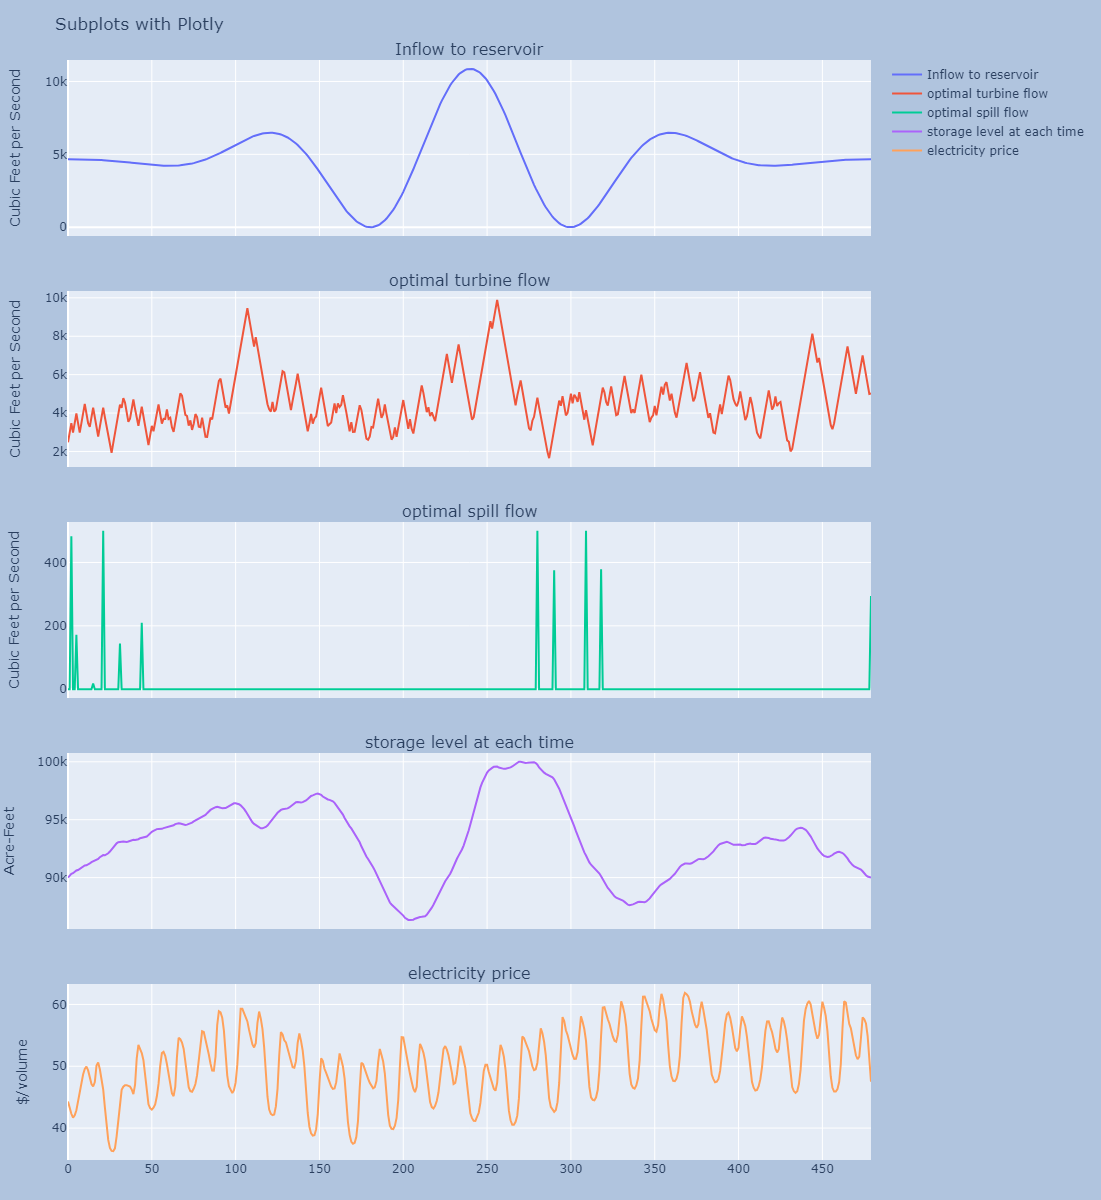

In [25]:
# Check the solver status
if results_electricity.solver.termination_condition == TerminationCondition.optimal:
    # Access the optimal values
    print('the optimization has been successful and optimum variables have been stored')
    optimal_turbine_flow_ex3_1=  [value(instance.TurbineFlow[t]) for t in instance.Time]
    optimal_spill_flow_ex3_1 = [value(instance.SpillFlow[t]) for t in model.Time]
    optimal_storage_level_ex3_1 = [value(instance.ReservoirStorage[t]) for t in model.Time]
else:
    print("Solver did not converge to an optimal solution.")


# Create subplots with 5 rows and 1 column
fig = make_subplots(rows=5, cols=1, shared_xaxes=True,
                    vertical_spacing=0.05,
                    subplot_titles=('Inflow to reservoir', 'optimal turbine flow', 'optimal spill flow',
                                    'storage level at each time', 'electricity price'))

# Add traces to each subplot
fig.add_trace(go.Scatter(y=list(inflow_reservoir.values()), name='Inflow to reservoir'), row=1, col=1)
fig.add_trace(go.Scatter(y=optimal_turbine_flow_ex3_1, name='optimal turbine flow'), row=2, col=1)
fig.add_trace(go.Scatter(y=optimal_spill_flow_ex3_1, name='optimal spill flow'), row=3, col=1)
fig.add_trace(go.Scatter(y=optimal_storage_level_ex3_1, name='storage level at each time'), row=4, col=1)
fig.add_trace(go.Scatter(y=list(price.values()), name='electricity price'), row=5, col=1)
fig.update_yaxes(title_text='Cubic Feet per Second', row=1, col=1)
fig.update_yaxes(title_text='Cubic Feet per Second', row=2, col=1)
fig.update_yaxes(title_text='Cubic Feet per Second', row=3, col=1)
fig.update_yaxes(title_text='Acre-Feet', row=4, col=1)
fig.update_yaxes(title_text='$/volume', row=5, col=1)
fig.update_layout(margin=dict(l=40, r=40, t=60, b=40),  # Adjust margins as needed
                  paper_bgcolor="LightSteelBlue",  # Set background color
                  )
# Update layout
fig.update_layout(height=1200, width=800,
                  title_text="Subplots with Plotly")

# Show the plot
fig.show()


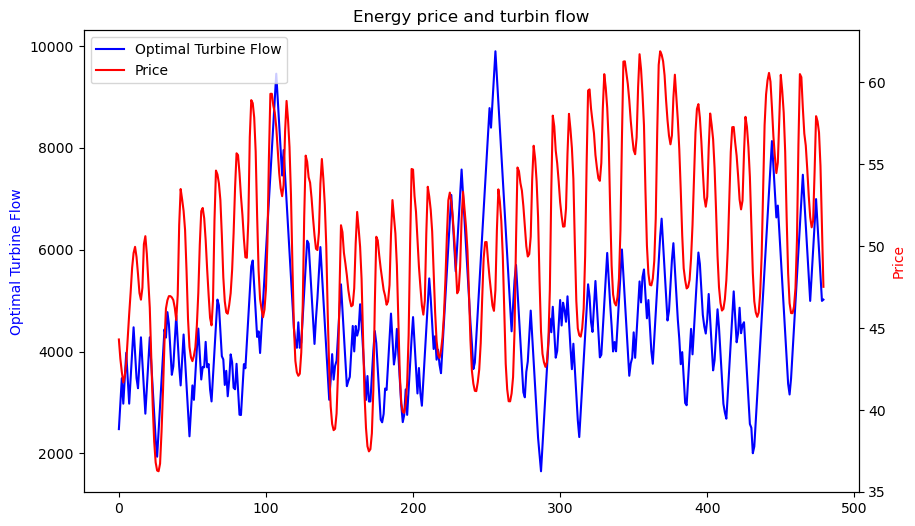

In [26]:
# Create figure and axis objects with a larger size
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Optimal Turbine Flow on the first y-axis
ax1.plot(range(len(optimal_turbine_flow_ex3_1)), optimal_turbine_flow_ex3_1, color='b', label='Optimal Turbine Flow')
ax1.set_ylabel('Optimal Turbine Flow', color='b')

# Create a second y-axis
ax2 = ax1.twinx()

# Plot Price on the second y-axis
ax2.plot(list(price.keys()), list(price.values()), color='r', label='Price')
ax2.set_ylabel('Price', color='r')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Set x-axis label
plt.xlabel('Time step')

# Set plot title
plt.title('Energy price and turbin flow')

# Show plot
plt.show()

At each time step, municipal demand is guaranteed by spill flow, and turbin flow occurs at higher energy prices. The majority of the cheap electricity prices have no flow from turbinflow.

# Exercise 2

2. Now consider the hypothetical case that the reservoir manager could choose to forego supplying municipal water at certain times if it wishes; that is, we no longer have the constraint of ssatisfying municipal demand at all times. Also assume that the water supplied to municipal use has a fixed pre-agreed price $\alpha  >0$ (dollars /Volume). What is the lowes such price $\alpha$  that will result in the municipal user being guaranteed supply at all times for the given inflow, storage, energy price, municipal demand data set used in Exercise 1? Find such alpha by solving an appropriate optimisation problem,  by using the multiple constrained formulations in exercise 1 and exercise 3 or any other (analytical) method.

### objective function

The objective function for the hydroelectric dam model is designed to maximize the total revenue from electricity generation and municipal water supply. It is defined as follows:
$$
\text{Maximize} \quad \sum_{t=1}^{T} \left( \left( Q_{\text{turbine}}[t] \times \left( 0.5 \times k1 \times (S[t] + S[t-1]) + k2 \right) \right) \times P_{\text{elec}}[t] + \alpha \times Q_{\text{spill}}[t] \right)
$$where:
- `Q_turbine[t]`: Turbine flow at time `t` (cubic feet per second, CFS)
- `S[t]`: Reservoir storage level at time `t` (Acre-Feet)
- `k1`, `k2`: Constants for power generation calculation
- `P_elec[t]`: Price of electricity per MWh at time `t`
- `alpha`: Price per thousand cubic feet of water supplied to the municipality
- `Q_spill[t]`: Flow of water supplied to the municipality at time `t` (CFS)
- `T`: Total time periods in the model model.alpha \times Q_{\text{spill}}[t] \) represents the revenue from municipal water supply, where \( \alpha \) is given in \$ per thousand cubic feet.


# Note for the exercise
below i again included everything to not get confused for the deleting or adding components to abstract model

In [47]:
#Create an abstract model
# Create an abstract model
model = AbstractModel()
# Define the range set for time
model.Time = RangeSet(0, N)

# Define parameters
model.inFlow = Param(model.Time, initialize=inflow_reservoir, mutable=False)
model.eprice = Param(model.Time, initialize=price, mutable=False)
model.muni_demand = Param(model.Time, initialize=municipal_demand, mutable=False)

# Constants as parameters
model.k1 = Param(initialize=k1, mutable=False)
model.k2 = Param(initialize=k2, mutable=False)
model.MW2kW = Param(initialize=MW2kW, mutable=False)
model.C2A = Param(initialize=C2A, mutable=False)
model.InitialStorage = Param(initialize=initial_storage, mutable=False)

# Define alpha as a mutable parameter
model.alpha = Param(mutable=True ,initialize=0.7, within=NonNegativeReals)

# Decision variables
model.TurbineFlow = Var(model.Time, within=NonNegativeReals, bounds=(Turbin_lb, Turbin_ub))
model.SpillFlow = Var(model.Time, within=NonNegativeReals, bounds=(0, None))
model.ReservoirStorage = Var(model.Time, bounds=(storage_lb, storage_ub))

def objective_function(model):
    # Correcting how `alpha` is used. It should be multiplied by the `model.muni_demand[t]` value for each time period `t`.
    # Also, ensure the entire term is indexed and calculated properly within the sum.
    return sum(((model.TurbineFlow[t] * (0.5 * model.k1 * (model.ReservoirStorage[t] + model.ReservoirStorage[t-1]) + model.k2)) * model.eprice[t]/1000  +
                model.alpha * model.SpillFlow[t] ) for t in model.Time if t > 0)
model.Objective = Objective(rule=objective_function, sense=maximize)

# Define derived variable and associated constraint
def reservoir_storage_rule(model, t):
    if t == 0:
        return model.ReservoirStorage[t] == 90000
    return model.ReservoirStorage[t] == model.ReservoirStorage[t-1] + model.C2A * (model.inFlow[t-1] - model.TurbineFlow[t-1] - model.SpillFlow[t-1])
    
model.ReservoirStorageConstraint = Constraint(model.Time, rule=reservoir_storage_rule)



# Define the constraint
def change_SpillFlow(model, t):
    if t == 0:
        return Constraint.Skip  # Skip the first time period as there is no previous time period
    else:
        return model.SpillFlow[t] - model.SpillFlow[t-1] <= max_change_turbin

model.change_flow_change_SpillFlow = Constraint(model.Time, rule=change_SpillFlow)

def change_SpillFlow_1(model, t):
    if t == 0:
        return Constraint.Skip  # Skip the first time period as there is no previous time period
    else:
        return model.SpillFlow[t] - model.SpillFlow[t-1] >= -max_change_turbin

model.change_flow_change_SpillFlow_1 = Constraint(model.Time, rule=change_SpillFlow_1)


# Define the constraint
def change_TurbineFlow(model, t):
    if t == 0:
        return Constraint.Skip  # Skip the first time period as there is no previous time period
    else:
        return (model.TurbineFlow[t] - model.TurbineFlow[t-1]) <= max_change_turbin

model.change_flow_change_TurbineFlow = Constraint(model.Time, rule=change_TurbineFlow)

# Define the constraint
def change_TurbineFlow_1(model, t):
    if t == 0:
        return Constraint.Skip  # Skip the first time period as there is no previous time period
    else:
        return (model.TurbineFlow[t] - model.TurbineFlow[t-1]) >= -max_change_turbin

model.change_flow_change_TurbineFlow_1 = Constraint(model.Time, rule=change_TurbineFlow_1)


def min_flow_change_rule(model, t):
    '''
    Defining the minimum spill and turbin flow at each time step
    '''
    return model.TurbineFlow[t] + model.SpillFlow[t] >= combine_spill_turbin

model.CombinedTurbinSpills = Constraint(model.Time, rule=min_flow_change_rule)


# Set initial and final reservoir storage constraints
def initial_reservoir_storage_rule(model):
    '''
    Setting initial storage in reservoir'''
    return model.ReservoirStorage[0] - model.ReservoirStorage[N]  <= 10e-8
    
model.InitialReservoirStorage = Constraint(rule=initial_reservoir_storage_rule)


def check_demand_satisfaction(instance):
    for t in instance.Time:
        if t > 0:  # Assuming time starts at 1 for calculations
            total_flow = value(instance.TurbineFlow[t]) + value(instance.SpillFlow[t])  # Add other flows if applicable
            demand = value(instance.muni_demand[t])
            if total_flow < demand:
                return False  # As soon as one demand is not met, return False
    return True  # All demands are met

# Set initial values
alpha_min = 0.0
alpha_max = 30
step = 2  # Adjust step size based on desired precision
tolerance = 0.01  # Stopping condition tolerance, if needed
satisfactory_alpha = None

# Iterate over possible alpha values
for alpha in np.arange(alpha_min, alpha_max + step, step):
    instance.alpha = alpha
    solver.solve(instance)
    
    if check_demand_satisfaction(instance):
        satisfactory_alpha = alpha
        break  # Stop if the first satisfactory alpha is found

if satisfactory_alpha is not None:
    print(f"The lowest alpha that meets all municipal demands is {satisfactory_alpha}")
else:
    print("No satisfactory alpha found within the given range")

# # Solver setup
# instance = model.create_instance()
# solver = SolverFactory('ipopt')
# result = solver.solve(instance)
# print("Objective Function Value:", value(instance.Objective))

# # List of different alpha values to test
# alpha_values = np.arange(0.1 , 2 , 0.4)
# objective_values = []

# for alpha in alpha_values:
#     # Set the new value of alpha
#     instance.alpha = alpha
    
#     # Resolve the model with the new alpha value
#     result = solver.solve(instance)
    
#     # Record the objective function value
#     objective_values.append(value(instance.Objective))

# # Plotting alpha versus the objective function value
# plt.figure(figsize=(10, 5))
# plt.plot(alpha_values, objective_values, marker='o')
# plt.title('Alpha vs. Objective Function Value')
# plt.xlabel('Alpha')
# plt.ylabel('Objective Function Value')
# plt.grid(True)
# plt.show()


No satisfactory alpha found within the given range


# Plotting the result

## Exercise 4

In the above exercises, we have considered spilling as a free control variable. However, this may result in reservoir operations where it is possible to sometimes spill when the reservoir is not at full capacity. Now, consider this is not physically possible. In this exercise, we consider how to constrain spilling and the consequesnces on the reservoir operations.

* Consider again problem 2. in Exercise 2, specifically the  unment baseload demand optimisation problem. This time assume that the reservoir can only spill when it is full. Model this in your optimisation problem and discuss the methodology (or methodologies) and the results. This constraint could be implemented  by using integer variables (i.e. resulting in a mixed-integer problem) or introducing additional slack variables. As a minimum, consider the implementation of (Celeste et al, 2010). Please use its approach for your case, and discuss the approach and the results, and how you may have solved any limitations you encountered, if any. Consider The Mixed-integer case only as a bonus case.

* Next consider relaxing the constraint that the final and initial levels be the same. In what ways are the results different? In practice, not having this cylcical condition would mean perhaps worse performance over the next time period from a new initial condition. Modify your optimisation problem to show this.




## Reference
Celeste, A. B., & Billib, M. (2010). The role of spill and evaporation in reservoir optimization models. Water resources management, 24(4), 617-628.*










In [50]:
#Create an abstract model
model = AbstractModel()

# Define the range set for time
model.Time = RangeSet(0, N)

# Define parameters
model.inFlow = Param(model.Time , initialize = inflow_reservoir,mutable = False)

model.eprice = Param(model.Time , initialize = price,mutable = False)
model.muni_demand = Param(model.Time , initialize = municipal_demand,mutable = False)

# Define constants as parameters
model.k1 = Param(initialize = k1, mutable=False)
model.k2 = Param(initialize =k2, mutable=False)
model.MW2kW = Param(initialize =MW2kW, mutable=False)
model.C2A = Param(initialize =C2A , mutable=False)
model.InitialStorage = Param(initialize =initial_storage,mutable = False)

# Define decision variables
# model.delta is the variable that is used to calculate how much is the difference between current storage level and max storage level (upper boundary)
model.delta = Var(model.Time, within = NonNegativeReals, bounds=(0,None)) 

# Turbin flow is confined from 0 to 10000
model.TurbineFlow = Var(model.Time, within=NonNegativeReals, bounds=(Turbin_lb, Turbin_ub), initialize = 0)
# model.TurbineFlow = Var(model.Time)

#Spill flow needs to be possitive
model.SpillFlow = Var(model.Time, within=NonNegativeReals, bounds = (0, None), initialize = 0)

#defining the storage size
model.ReservoirStorage = Var(model.Time, bounds=(storage_lb,storage_ub))


def UnmetDemandObj(model):
    def Unmetdemand(t):
        if t==0:
            return 0
        else:
            return ( 1000 * (((model.TurbineFlow[t] * 0.5 * model.k1 * (model.ReservoirStorage[t] + model.ReservoirStorage[t-1])
                     + model.k2) - baseload_applied)/ baseload_applied) ** 2) + model.SpillFlow[t] + model.delta[t]
    return sum([Unmetdemand(i) for i in model.Time])
model.obj = Objective(rule=UnmetDemandObj, sense=minimize)


#mass balance of storage
def StorageLevel(model, t):
    if t==0:
        return model.ReservoirStorage[t] == 90000
    return model.ReservoirStorage[t] == (model.ReservoirStorage[t-1] + model.C2A * (model.inFlow[t-1] - model.SpillFlow[t-1] - model.TurbineFlow[t-1]))
model.Reservoir = Constraint(model.Time, rule = StorageLevel)

#to have spills whenever it is full
def DeficitVar(model, t):
    if t == 0:
        return Constraint.Skip
    return (model.ReservoirStorage[t-1] +  model.C2A * (model.inFlow[t] - model.SpillFlow[t] - model.TurbineFlow[t] + model.delta[t])) == storage_ub
model.DefVariable = Constraint(model.Time, rule = DeficitVar)

def DefZero(model, t):
    '''this function guarantee that at every timestep the baseload in supuplied'''
    if t == 0:
        return Constraint.Skip  # Skip for the initial time step, or handle it according to your model's specifics
    else :
        return model.SpillFlow[t]/10000 * model.delta[t]/storage_ub == 0
model.ZeroComplementary = Constraint(model.Time, rule=DefZero)


    
# Define the constraint related to changing the spill flow at each time step for positive 500
def change_SpillFlow(model, t):
    if t == 0:
        return Constraint.Skip  # Skip the first time period as there is no previous time period
    else:
        return model.SpillFlow[t] - model.SpillFlow[t-1] <= max_change_turbin
model.change_flow_change_SpillFlow = Constraint(model.Time, rule=change_SpillFlow)

# Define the constraint related to changing the spill flow at each time step for minus 500
def change_SpillFlow_minus(model, t):
    if t == 0:
        return Constraint.Skip  # Skip the first time period as there is no previous time period
    else:
        return model.SpillFlow[t] - model.SpillFlow[t-1] >= -max_change_turbin

model.change_flow_change_SpillFlow_1 = Constraint(model.Time, rule=change_SpillFlow_minus)


# Define the constraint related to changing the turbine flow at each time step for positive 500
def change_TurbineFlow(model, t):
    if t == 0:
        return Constraint.Skip  # Skip the first time period as there is no previous time period
    else:
        return (model.TurbineFlow[t] - model.TurbineFlow[t-1]) <= max_change_turbin

model.change_flow_change_TurbineFlow = Constraint(model.Time, rule=change_TurbineFlow)

# Define the constraint related to changing the turbine flow at each time step for minus 500
def change_TurbineFlow_minus(model, t):
    if t == 0:
        return Constraint.Skip  # Skip the first time period as there is no previous time period
    else:
        return (model.TurbineFlow[t] - model.TurbineFlow[t-1]) >= -max_change_turbin

model.change_flow_change_TurbineFlow_1 = Constraint(model.Time, rule=change_TurbineFlow_minus)


#To satisfy minimum flow
def min_flow_change_rule(model, t):
    '''
    Defining the minimum spill and turbin flow at each time step
    '''
    return model.TurbineFlow[t] + model.SpillFlow[t] >= combine_spill_turbin
model.CombinedTurbinSpills = Constraint(model.Time, rule=min_flow_change_rule)


# Set initial and final reservoir storage constraints
def initial_reservoir_storage_rule(model):
    '''
    Setting initial storage in reservoir'''
    return model.ReservoirStorage[0] == model.ReservoirStorage[N]  
model.InitialReservoirStorage = Constraint(rule=initial_reservoir_storage_rule)




# # Solve the optimization problem
opt = SolverFactory('ipopt')  # Choose the solver
instance = model.create_instance()  # Create an instance of the model
results = opt.solve(instance)  # Solve the instance


In [51]:
# Check the solver status
if results_electricity.solver.termination_condition == TerminationCondition.optimal:
    # Access the optimal values
    print('the optimization has been successful and optimum variables have been stored')
    optimal_turbine_flow_ex4_1=  [value(instance.TurbineFlow[t]) for t in instance.Time]
    optimal_spill_flow_ex4_1 = [value(instance.SpillFlow[t]) for t in model.Time]
    optimal_storage_level_ex4_1 = [value(instance.ReservoirStorage[t]) for t in model.Time]
    # delta = [value(instance.delta[t]) for t in model.Time]
else:
    print("Solver did not converge to an optimal solution.")


# Create subplots with 5 rows and 1 column
fig = make_subplots(rows=5, cols=1, shared_xaxes=True,
                    vertical_spacing=0.05,
                    subplot_titles=('Inflow to reservoir', 'optimal turbine flow', 'optimal spill flow',
                                    'storage level at each time', 'electricity price'))

# Add traces to each subplot
fig.add_trace(go.Scatter(y=list(inflow_reservoir.values()), name='Inflow to reservoir'), row=1, col=1)
fig.add_trace(go.Scatter(y=optimal_turbine_flow_ex4_1, name='optimal turbine flow'), row=2, col=1)
fig.add_trace(go.Scatter(y=optimal_spill_flow_ex4_1, name='optimal spill flow'), row=3, col=1)
fig.add_trace(go.Scatter(y=optimal_storage_level_ex4_1, name='storage level at each time'), row=4, col=1)
fig.add_trace(go.Scatter(y=list(price.values()), name='electricity price'), row=5, col=1)

# Update layout
fig.update_layout(height=1200, width=800,
                  title_text="Subplots with Plotly")
fig.update_layout(margin=dict(l=40, r=40, t=60, b=40),  # Adjust margins as needed
                  paper_bgcolor="LightSteelBlue",  # Set background color
                  )
# Show the plot
fig.show()

the optimization has been successful and optimum variables have been stored


AttributeError: 'numpy.float64' object has no attribute 'values'

### relaxing the initial and final equality size

In [31]:
model.del_component(model.InitialReservoirStorage)  # Delete the initial storage level constraints

In [32]:
# Create a concrete instance of the abstract model
instance = model.create_instance()

# Specify the solver
solver = SolverFactory('ipopt')

# Solve the instance
results = solver.solve(instance)

# Check solver termination condition
if results.solver.termination_condition == TerminationCondition.optimal:
    # Print optimal solution
    print("Optimal solution found.")
else:
    print("Solver did not converge to an optimal solution.")

Optimal solution found.


the optimization has been successful and optimum variables have been stored


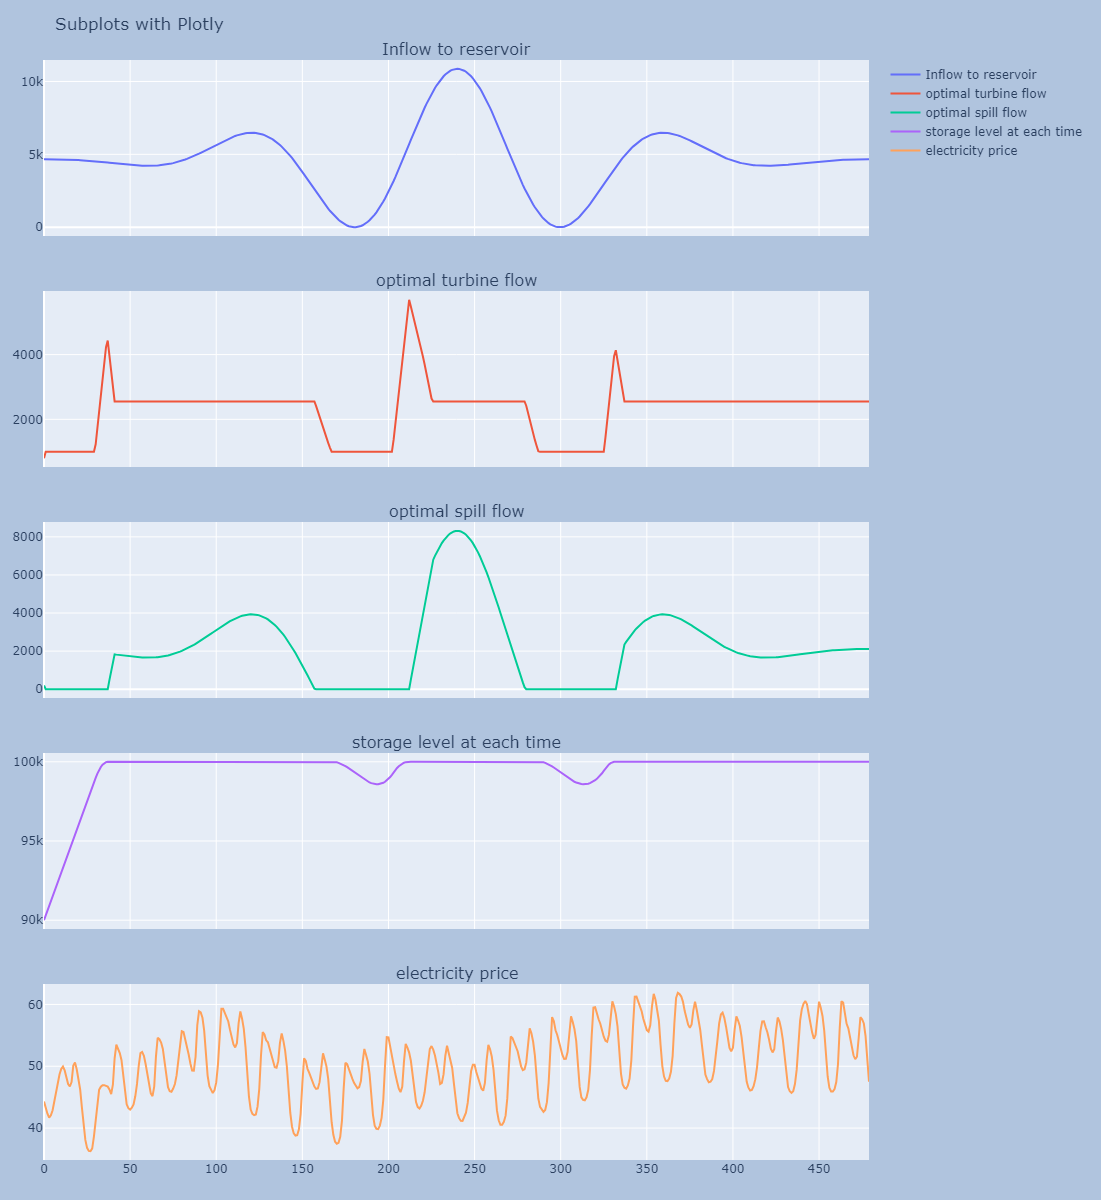

In [33]:
# Check the solver status
if results_electricity.solver.termination_condition == TerminationCondition.optimal:
    # Access the optimal values
    print('the optimization has been successful and optimum variables have been stored')
    optimal_turbine_flow_ex4_2=  [value(instance.TurbineFlow[t]) for t in instance.Time]
    optimal_spill_flow_ex4_2 = [value(instance.SpillFlow[t]) for t in model.Time]
    optimal_storage_level_ex4_2 = [value(instance.ReservoirStorage[t]) for t in model.Time]
else:
    print("Solver did not converge to an optimal solution.")


# Create subplots with 5 rows and 1 column
fig = make_subplots(rows=5, cols=1, shared_xaxes=True,
                    vertical_spacing=0.05,
                    subplot_titles=('Inflow to reservoir', 'optimal turbine flow', 'optimal spill flow',
                                    'storage level at each time', 'electricity price'))

# Add traces to each subplot
fig.add_trace(go.Scatter(y=list(inflow_reservoir.values()), name='Inflow to reservoir'), row=1, col=1)
fig.add_trace(go.Scatter(y=optimal_turbine_flow_ex4_2, name='optimal turbine flow'), row=2, col=1)
fig.add_trace(go.Scatter(y=optimal_spill_flow_ex4_2, name='optimal spill flow'), row=3, col=1)
fig.add_trace(go.Scatter(y=optimal_storage_level_ex4_2, name='storage level at each time'), row=4, col=1)
fig.add_trace(go.Scatter(y=list(price.values()), name='electricity price'), row=5, col=1)

# Update layout
fig.update_layout(height=1200, width=800,
                  title_text="Subplots with Plotly")
fig.update_layout(margin=dict(l=40, r=40, t=60, b=40),  # Adjust margins as needed
                  paper_bgcolor="LightSteelBlue",  # Set background color
                  )
# Show the plot
fig.show()

Now the model does not use spill for reaching to the cyclic constraint (inital and final storage being the same)

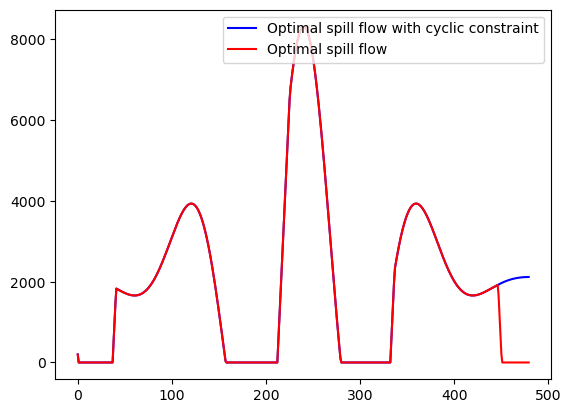

In [34]:
# Create figure and axis objects with a larger size
# Plot Optimal Turbine Flow on the first y-axis
plt.plot(range(len(optimal_spill_flow_ex4_2)), optimal_spill_flow_ex4_2, color='b', label='Optimal spill flow with cyclic constraint')
plt.plot(range(len(optimal_spill_flow_ex4_1)), optimal_spill_flow_ex4_1, color='r', label='Optimal spill flow ')
plt.legend()

It does not use spill flow to meet the demand of having the initial and final stages at the same level of storage.
